In [1]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import seaborn as sns
import matplotlib.pyplot as plt

import patsy as pat
import statsmodels.api as sm

This notebook demonstrates using normative modeling with multivariate confounds, specifically age, sex and multisite correction.

## **Generate data**

In [2]:
def model(age, sex, offset):
    noise = np.random.normal(0, 0.1)
    return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0, 0.3) * sex + offset


def model_prob(age, sex, offset):
    noise = np.random.normal(0, 0.1)
    return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0, 0.3) * sex - 0.2 * np.random.uniform() + offset

def generate_data(group='PROB_CON', sample_size=1, n_sites=2, randseed=3):
    np.random.seed(randseed)
    n_sites = n_sites
    age_min = (np.random.rand(n_sites)*50).astype(int)
    sites = pd.DataFrame(data={'sex_ratio': np.random.rand(n_sites),
                               'prob_ratio': 0.5*np.random.rand(n_sites),
                               'age_min': age_min,
                               'age_max': (age_min+5+np.random.rand(n_sites)*50).astype(int),
                               'score_shift': np.random.randn(n_sites)/4,
                               'sample_size': (sample_size+np.random.rand(n_sites)*sample_size*10).astype(int)})

    participants = []
    for site in sites.iterrows():
        for participant in range(int(site[1]['sample_size'])):
            sex = np.random.binomial(1, site[1]['sex_ratio'])
            prob = np.random.binomial(1, site[1]['prob_ratio'])
            age = np.random.uniform(site[1]['age_min'], site[1]['age_max'])
            if prob:
                score = model_prob(age, sex, site[1]['score_shift'])
            else:
                score = model(age, sex, site[1]['score_shift'])
            participants.append([site[0], sex, prob, age, score])

    df = pd.DataFrame(participants, columns=['site', 'sex', 'group', 'age', 'score'])
    df.sex.replace({1: 'Female', 0: 'Male'}, inplace=True)
    if group == 'PROB_CON':
        df.group.replace({1: 'PROB', 0: 'CTR'}, inplace=True)
    return df

In [4]:
df = generate_data(n_sites=5,sample_size=35,randseed=650)
print('n subjects = {}'.format(df.shape[0]))

n subjects = 878


## **Visualize data**

Text(0.5, 1.0, 'By sex')

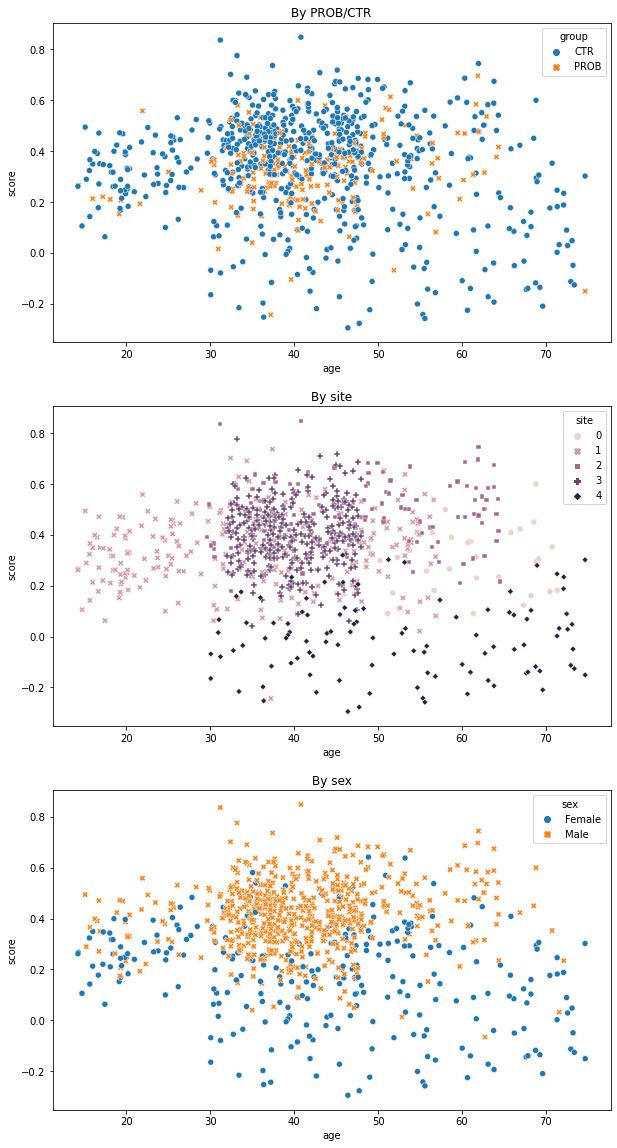

In [5]:
fig,ax = plt.subplots(3,1,figsize=(10,20))

sns.scatterplot(data=df, x='age', y='score', hue='group', style='group',ax=ax[0])
sns.scatterplot(data=df, x='age', y='score', hue='site', style='site',ax=ax[1])
sns.scatterplot(data=df, x='age', y='score', hue='sex', style='sex',ax=ax[2])

ax[0].set_title('By PROB/CTR')
ax[1].set_title('By site')
ax[2].set_title('By sex')

Text(0.5, 1.0, 'By sex')

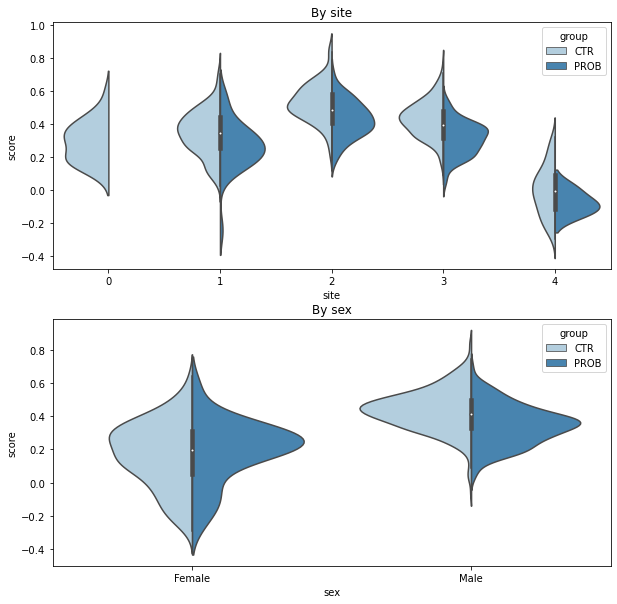

In [6]:
fig,ax = plt.subplots(2,1,figsize=(10,10))

sns.violinplot(x='site',y='score',data=df,split=True,palette='Blues',hue='group',ax=ax[0])
sns.violinplot(x='sex',y='score',data=df,split=True,palette='Blues',hue='group',ax=ax[1])

ax[0].set_title('By site')
ax[1].set_title('By sex')

## **PyNM - Normative Modeling**

In [7]:
#Initialize pynm w/ data and confounds
m = PyNM(df,'score','group',
        conf = 'age',                           #age confound for LOESS and Centiles model
        confounds = ['age','c(sex)','c(site)']) #multivarite confounds for GP model

Models will be fit on full set of controls.


In [10]:
#Run models
m.loess_normative_model()
m.centiles_normative_model()
m.gp_normative_model()
m.gamlss_normative_model(mu='score ~ ps(age) + c(sex) + c(site)',sigma = '~ ps(age)',family='SHASHo2')

#Collect output
data = m.data

/home/harveyaa/Documents/normative_modeling/PyNM/pynm/pynm.py:441: RuntimeWarning: invalid value encountered in greater_equal
  result[else_mask] = np.array([np.argmin(self.data[self.score][i] >= centiles[i]) for i in range(self.data.shape[0])])[else_mask]
/home/harveyaa/miniconda3/envs/GPyTorch/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


GAMLSS-RS iteration 1: Global Deviance = -560.6306 
GAMLSS-RS iteration 2: Global Deviance = -705.226 
GAMLSS-RS iteration 3: Global Deviance = -748.7197 
GAMLSS-RS iteration 4: Global Deviance = -763.9267 
GAMLSS-RS iteration 5: Global Deviance = -770.0467 
GAMLSS-RS iteration 6: Global Deviance = -772.7786 
GAMLSS-RS iteration 7: Global Deviance = -774.1144 
GAMLSS-RS iteration 8: Global Deviance = -774.79 
GAMLSS-RS iteration 9: Global Deviance = -775.2541 
GAMLSS-RS iteration 10: Global Deviance = -775.5021 
GAMLSS-RS iteration 11: Global Deviance = -775.6641 
GAMLSS-RS iteration 12: Global Deviance = -775.7696 
GAMLSS-RS iteration 13: Global Deviance = -775.8416 
GAMLSS-RS iteration 14: Global Deviance = -775.889 
GAMLSS-RS iteration 15: Global Deviance = -775.9199 
GAMLSS-RS iteration 16: Global Deviance = -775.9398 
GAMLSS-RS iteration 17: Global Deviance = -775.9522 
GAMLSS-RS iteration 18: Global Deviance = -775.9598 
GAMLSS-RS iteration 19: Global Deviance = -775.964 
GAMLSS-

## **Visualize Normative Models**

Text(0.5, 1.0, 'GAMLSS')

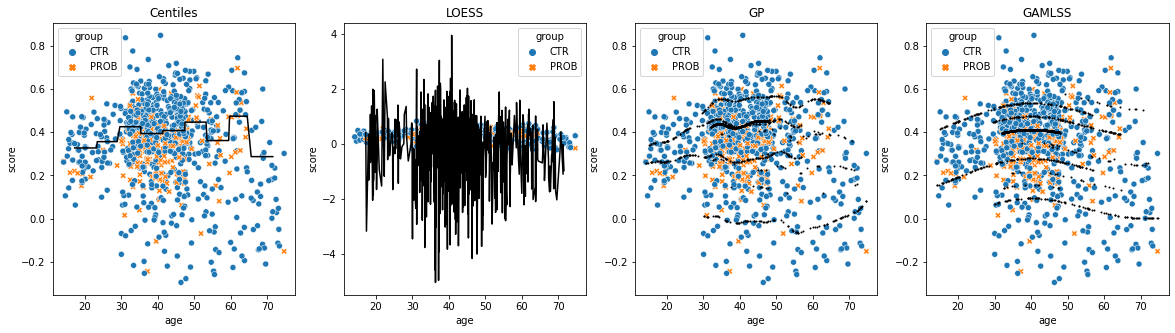

In [11]:
fig,ax = plt.subplots(1,4,figsize=(20,5))
for i in range(4):
    sns.scatterplot(data=m.data, x='age', y='score',
                             hue='group', style='group',ax=ax[i])
tmp = m.data.sort_values('age')
ax[0].plot(tmp['age'], tmp['Centiles_pred'], '-k')
ax[1].plot(tmp['age'], tmp['LOESS_pred'], '-k')
ax[2].scatter(tmp['age'], tmp['GP_pred'],color='black',s=1)
ax[3].scatter(tmp['age'], tmp['GAMLSS_pred'],color='black',s=1)

ax[0].set_title('Centiles')
ax[1].set_title('LOESS')
ax[2].set_title('GP')
ax[3].set_title('GAMLSS')

Text(0.5, 1.0, 'GAMLSS')

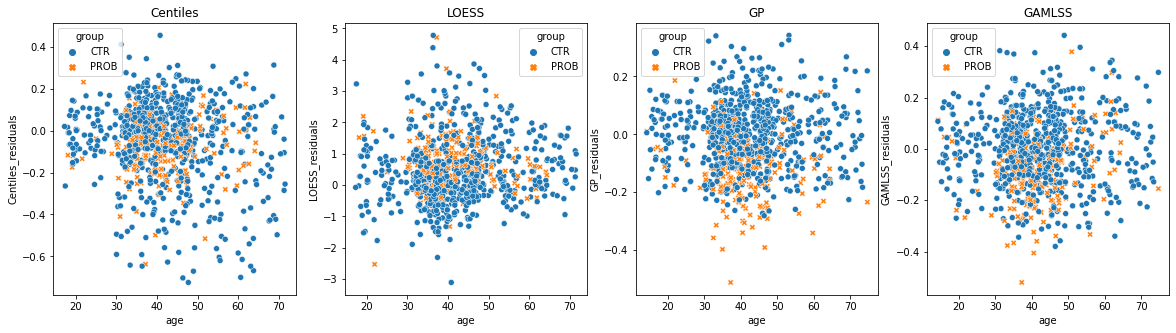

In [12]:
fig,ax = plt.subplots(1,4,figsize=(20,5))

sns.scatterplot(data=data,x='age', y='Centiles_residuals',hue='group',style='group',ax=ax[0])
sns.scatterplot(data=data,x='age', y='LOESS_residuals',hue='group',style='group',ax=ax[1])
sns.scatterplot(data=data,x='age', y='GP_residuals',hue='group',style='group',ax=ax[2])
sns.scatterplot(data=data,x='age', y='GAMLSS_residuals',hue='group',style='group',ax=ax[3])

ax[0].set_title('Centiles')
ax[1].set_title('LOESS')
ax[2].set_title('GP')
ax[3].set_title('GAMLSS')

Text(0.5, 1.0, 'GAMLSS')

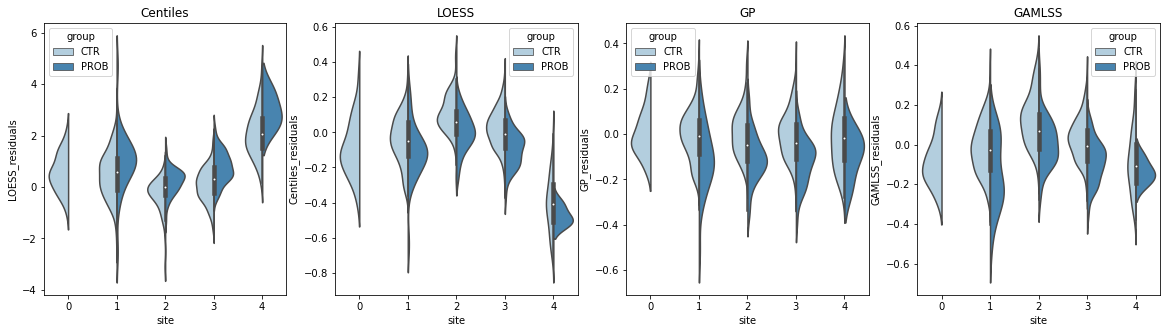

In [13]:
fig,ax = plt.subplots(1,4,figsize=(20,5))

sns.violinplot(x='site',y='LOESS_residuals',data=m.data,split=True,palette='Blues',hue='group',ax=ax[0])
sns.violinplot(x='site',y='Centiles_residuals',data=m.data,split=True,palette='Blues',hue='group',ax=ax[1])
sns.violinplot(x='site',y='GP_residuals',data=m.data,split=True,palette='Blues',hue='group',ax=ax[2])
sns.violinplot(x='site',y='GAMLSS_residuals',data=m.data,split=True,palette='Blues',hue='group',ax=ax[3])

ax[0].set_title('Centiles')
ax[1].set_title('LOESS')
ax[2].set_title('GP')
ax[3].set_title('GAMLSS')

Text(0.5, 1.0, 'GAMLSS')

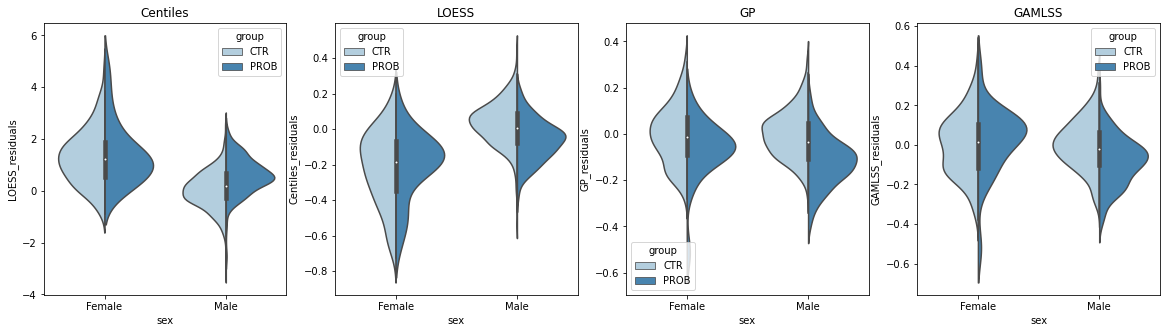

In [14]:
fig,ax = plt.subplots(1,4,figsize=(20,5))

sns.violinplot(x='sex',y='LOESS_residuals',data=m.data,split=True,palette='Blues',hue='group',ax=ax[0])
sns.violinplot(x='sex',y='Centiles_residuals',data=m.data,split=True,palette='Blues',hue='group',ax=ax[1])
sns.violinplot(x='sex',y='GP_residuals',data=m.data,split=True,palette='Blues',hue='group',ax=ax[2])
sns.violinplot(x='sex',y='GAMLSS_residuals',data=m.data,split=True,palette='Blues',hue='group',ax=ax[3])

ax[0].set_title('Centiles')
ax[1].set_title('LOESS')
ax[2].set_title('GP')
ax[3].set_title('GAMLSS')

## **Case-control**

In [15]:
def case_control(df, group='group',score='score'):
    dmat = pat.dmatrix('C({})'.format(group), df, return_type='dataframe',NA_action='raise')
    results = sm.OLS(m.data[score],dmat).fit()
    return results.pvalues[1]

In [16]:
p_uncorrected = case_control(m.data,score='score')
p_centiles = case_control(m.data,score='Centiles_residuals')
p_loess = case_control(m.data,score='LOESS_residuals')
p_gp = case_control(m.data,score='GP_residuals')
p_gamlss = case_control(m.data,score='GAMLSS_residuals')

print('Uncorrected: p =', p_uncorrected)
print('Centiles: p =', p_centiles)
print('LOESS: p =', p_loess)
print('GP: p =', p_gp)
print('GAMLSS: p =', p_gamlss)

Uncorrected: p = 0.24462171163807975
Centiles: p = nan
LOESS: p = nan
GP: p = 4.623537017718543e-34
GAMLSS: p = 1.1199077045267118e-11
